Do you want to input a custom layout file? (yes/no):  no
Enter a string to analyze for key press frequency and travelled distance by fingers :  uftdrg


Total finger travel distance: 33.04 units


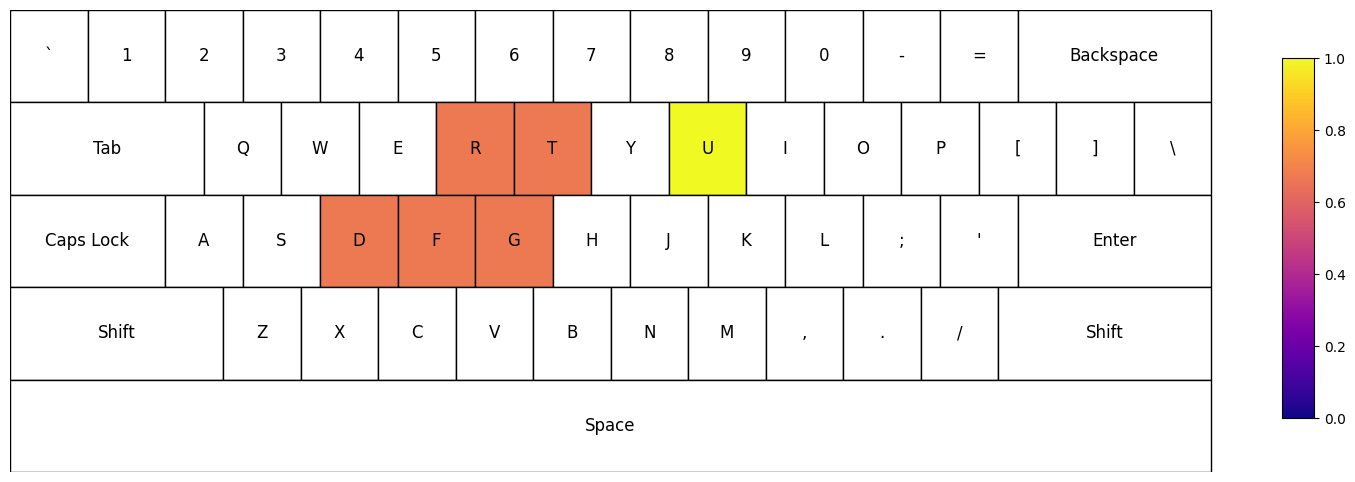

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib import animation
import math

# I have defined Qwerty as my defaykt Keyboard layout
default_keys = [
    ['`', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', '=', 'Backspace'],
    ['Tab', 'Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P', '[', ']', '\\'],
    ['Caps Lock', 'A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L', ';', '\'', 'Enter'],
    ['Shift', 'Z', 'X', 'C', 'V', 'B', 'N', 'M', ',', '.', '/', 'Shift'],
    ['Space' ]
]

# Since the size of some key are different from regualr i have defiend the size sepeartely
key_sizes = {
    'Backspace': 2.5, 'Tab': 2.5, 'Caps Lock': 2, 'Enter': 2.5, 'Shift': 2.75,
    'Space': 15.5,
}

# Define key coordinates for distance calculation
key_coords = {}
for row_idx, row in enumerate(default_keys):
    x_start = 0
    for key in row:
        key_coords[key.upper()] = (x_start, row_idx)
        width = key_sizes.get(key, 1)
        x_start += width

# Function to calculate Euclidean distance as mentioned in the file shared by Sir
def calculate_distance(key1, key2):
    if isinstance(key2, tuple):
        x2, y2 = key2
    else:
        if key2 not in key_coords:
            return 0  
        x2, y2 = key_coords[key2] #Here i have used the key_cords defined above to get the coordinates of the second key
    
    # Get coordinates for the first key
    if key1 not in key_coords:
        return 0  
    x1, y1 = key_coords[key1]
    
    # Calcu;ating distance using Euclidean Formula
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# This function takes input string and keys and returns the key counts and distance also it handles the various cases of special keys
def count_key_presses_and_calculate_distance(input_string, keys):
    input_string = input_string  # Keep case sensitivity for Shift detection
    flattened_keys = [key for row in keys for key in row]  # Flatten the 2D list into 1D
    key_counts = {key: 0 for key in flattened_keys}

    # Handle space key
    space_key_candidates = [key for key in flattened_keys if 'space' in key.lower()]
    space_key = space_key_candidates[0] if space_key_candidates else None

    # Special keys
    shift_left = 'Shift'
    caps_lock = 'Caps Lock'
    total_distance = 0
    home_position = (8, 0)
    caps_lock_active = False

    for char in input_string:
        if char.isupper() and not caps_lock_active:
            # Uppercase letter, Shift needs to be pressed
            key_counts[shift_left] += 1
            distance_from_home_shift = calculate_distance(shift_left, home_position)
            total_distance += 2 * distance_from_home_shift  

        elif char.islower() and caps_lock_active:
            # Lowercase letter while Caps Lock is active, turn off Caps Lock
            key_counts[caps_lock] += 1
            caps_lock_active = False  
            distance_from_home_caps = calculate_distance(caps_lock, home_position)
            total_distance += 2 * distance_from_home_caps

        # Check if Caps Lock needs to be activated
        if char.isupper() and not caps_lock_active:
            key_counts[caps_lock] += 1
            caps_lock_active = True  
            distance_from_home_caps = calculate_distance(caps_lock, home_position)
            total_distance += 2 * distance_from_home_caps

        # Handle normal keypresses
        if char.upper() in key_counts:
            key_counts[char.upper()] += 1
            distance_from_home = calculate_distance(char.upper(), home_position)
            total_distance += 2 * distance_from_home  

        elif char == ' ' and space_key:
            key_counts[space_key] += 1
            distance_from_home = calculate_distance(space_key, home_position)
            total_distance += 2 * distance_from_home  

    return key_counts, total_distance

def main():
    # Asking user if they want to use custom layout or go with default one
    while True:
        use_custom_layout = input("Do you want to input a custom layout file? (yes/no): ").lower()
        if use_custom_layout in ['yes', 'no']:
            break
        print("Please give a valid input (yes or no).")

    custom_layout = {}
    if use_custom_layout == 'yes':
        layout_file = input("Enter the custom keyboard layout file name (with .txt extension): ")

        # Read custom layout from file here I have added except to handle errors like file not found, syntax error 
        try:
            with open(layout_file, 'r') as file:
                custom_layout = eval(file.read())
        except (FileNotFoundError, SyntaxError):
            print("Invalid layout file therefore using default QWERTY layout.")
        except Exception as e:
            print(f"unexpected error occurred: {e} therefore sing default layout.")

    # Use default keys unless custom layout is valid
    keys = default_keys
    if custom_layout and all(f'row{i+1}' in custom_layout for i in range(4)):
        keys = [custom_layout[f'row{i+1}']['keys'] for i in range(4)]

# asking user for the input
    input_string = input("Enter a string to analyze for key press frequency and travelled distance by fingers : ")

    # passing values into the function and getting the key counts and total distance
    key_counts, total_distance = count_key_presses_and_calculate_distance(input_string, keys)

    print(f"Total finger travel distance: {total_distance:.2f} units")

    # Giving dimension for plot of keyboard and heatmap
    fig, ax = plt.subplots(figsize=(16, 6))
    key_width = 1.0
    key_height = 1.0


    cmap = plt.colormaps.get_cmap('plasma')
    max_count = max(key_counts.values()) if max(key_counts.values()) > 0 else 1  # To avoid division by zero

# recangles list is used to store the rectangles of the keys
    rectangles = []

    # Function to draw the keyboard and heatmap
    def draw_keyboard_with_heatmap():
        y_start = 4
        for row_idx, row in enumerate(keys):
            x_start = 0
            y_pos = y_start - row_idx * key_height

            for key in row:
                width = key_sizes.get(key, key_width)
                rect = Rectangle((x_start, y_pos), width, key_height, fill=True, edgecolor='black', facecolor='white')
                ax.add_patch(rect)
                ax.text(x_start + width / 2, y_pos + key_height / 2, key, fontsize=12, ha='center', va='center')
                rectangles.append((rect, key))
                x_start += width

    # drawing the keyboard layout
    draw_keyboard_with_heatmap()

    # Seting plot limits and hiding the axes as it looks bad
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 5)
    ax.axis('off') 

    # Adding colorbar 
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position for the colorbar
    ColorbarBase(cbar_ax, cmap=cmap)



    def animate(i):
        global caps_lock_on
        char = input_string[i].upper()  # Convert the current character to uppercase for key matching
        shift_on = False
        caps_lock_on = False
    # Major assumption  is that If a Uppercase character is followed by lower case character i assume that user has used the shift key and travel distance for SHIFT_R and SHIFT_L is same 
    # and if a uppercase character is followed by another uppercase character i assume that user has used the caps lock key 
        # If the character is uppercase and not the last character, check for the next one
        if i < len(input_string) - 1:
            if input_string[i].isupper() and not input_string[i+1].isupper():
                shift_on = True
            if input_string[i].isupper() and input_string[i+1].isupper():
                caps_lock_on = True

        # Update the keyboard heatmap for each key press
        for rect, key in rectangles:
            # Checking if the key matches the current character or space
            if char == key or (input_string[i] == ' ' and key.lower() == 'space'):
                key_counts[key] += 1
                max_count = max(key_counts.values())  
                heat_intensity = key_counts[key] / max_count
                rect.set_facecolor(cmap(heat_intensity))
            # Handling of Shift key for uppercase letters
            if shift_on and key == 'Shift':
                key_counts['Shift'] += 1
                max_count = max(key_counts.values())  
                heat_intensity_shift = key_counts['Shift'] / max_count
                rect.set_facecolor(cmap(heat_intensity_shift))
            # Handling of Caps Lock key activation
            if caps_lock_on and key == 'Caps Lock':
                key_counts['Caps Lock'] += 1
                max_count = max(key_counts.values())  
                heat_intensity_caps = key_counts['Caps Lock'] / max_count
                rect.set_facecolor(cmap(heat_intensity_caps))
        # Checking if the current character is lowercase and Caps Lock is on
        if input_string[i].islower() and caps_lock_on:
            caps_lock_on = False
            for rect_caps, key_caps in rectangles:
                if key_caps == 'Caps Lock':
                    rect_caps.set_facecolor('white') 
    anim = animation.FuncAnimation(fig, animate, frames=len(input_string), interval=200)
    #plt.show()
    return anim


# if __name__ == "__main__":
anim = main()
from IPython.display import HTML
HTML(anim.to_jshtml())

